# OUT OF DATE

# Parametres

In [47]:
from torch.cuda import is_available as gpu_available
from torch import float32, Tensor
FILENAME : str = "../data/316_ideological_book_corpus/ibc.csv"

seed : int = 42

model_name : str = "answerdotai/ModernBERT-base"; embedding_dim : int = 768
att_implementation : str = "flash_attention_2" if gpu_available() else "sdpa"
device = "cuda" if gpu_available() else "cpu"
float_dtype = float32

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
def classifier_metrics(y_true : Tensor, y_pred : Tensor) -> dict[str:float]:
    y_true = y_true.to(bool, copy = True)
    y_pred = y_pred.to(bool, copy = True)
    
    return {
        'f1': f1_score(y_true=y_true, y_pred=y_pred, average='micro'),
        'roc_auc': roc_auc_score(y_true, y_pred, average = 'micro').item(),
        'accuracy': accuracy_score(y_true, y_pred)
    }

# from torch.nn import Threshold; threshold : Threshold = Threshold(0.4,0)
from torch import where as torch_where
def threshold(probabilities : Tensor, thresh_value : float = 0.4) -> Tensor :
    return torch_where(probabilities > 0.4,Tensor([1.0]).to(device),
                       Tensor([0.0]).to(device)).to(float_dtype)

n_epoch : int = 2

# Load parameters saved as json #TODO is it really necessary ??
import json
with open("../configs/316_ideology_sentence.json", "r") as file : 
    parameters = json.load(file)

# Exploration des données

Nombre de lignes dans le dataset :  4326


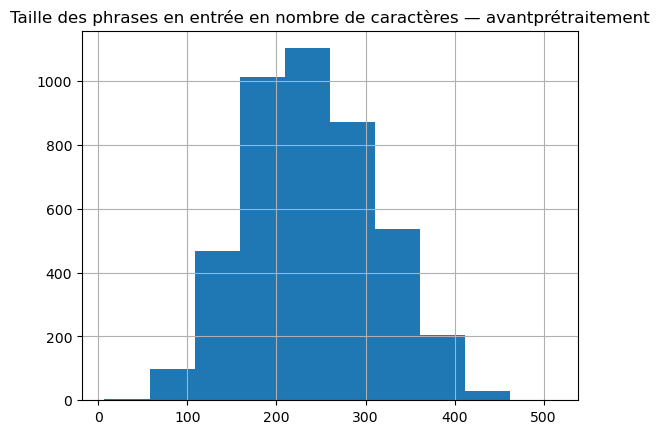

In [48]:
import pandas as pd

df = pd.read_csv(FILENAME).\
        astype({
            "sentence" : "str",
            "leaning" : "str"
        }).\
        rename({
            "sentence" : "in",
            "leaning" : "out"
        }, axis = 1)

len_in_col = ("Taille des phrases en entrée en nombre de caractères — avant"
              "prétraitement")
df[len_in_col] = df["in"].apply(len)
print("Nombre de lignes dans le dataset : ", len(df))
_ = df.hist(len_in_col)

In [49]:
LABEL : list[str] = list(set(df["out"])); n_labels : int = len(LABEL)
ID2LABEL : dict[int:str] = {i : cat for i,cat in enumerate(LABEL)}
LABEL2ID : dict[str:int] = {cat:i for i,cat in enumerate(LABEL)}
print("Categories : " + ", ".join([cat for cat in LABEL]),"\n")

Categories : Liberal, Conservative, Neutral 



In [50]:
class_size = df.groupby("out").size()
def dot2f(x):
    return int(x * 100) / 100
def div(col1, col2) : 
    return dot2f(class_size[col1] / class_size[col2])

print(f'| {"Label":<15} || {"Amount":<10} || {"Conservative":<15} | {"Liberal":<15} | {"Neutral" : <15} |')
print("-" * 88)
print(f'| {"Conservative":<15} || {class_size["Conservative"]:<10} || {div("Conservative","Conservative"):<15} | {div("Liberal","Conservative"):<15} | {div("Neutral","Conservative"): <15} |')
print(f'| {"Liberal":<15} || {class_size["Liberal"]:<10} || {div("Conservative","Liberal"):<15} | {div("Liberal","Liberal"):<15} | {div("Neutral","Liberal"): <15} |')
print(f'| {"Neutral":<15} || {class_size["Neutral"]:<10} || {div("Conservative","Neutral"):<15} | {div("Liberal","Neutral"):<15} | {div("Neutral","Neutral"): <15} |')
print("-" * 88)

del df, class_size, dot2f, div

| Label           || Amount     || Conservative    | Liberal         | Neutral         |
----------------------------------------------------------------------------------------
| Conservative    || 1701       || 1.0             | 1.19            | 0.35            |
| Liberal         || 2025       || 0.84            | 1.0             | 0.29            |
| Neutral         || 600        || 2.83            | 3.37            | 1.0             |
----------------------------------------------------------------------------------------


# Entraînement d'un classifieur

## Load the dataset

In [51]:
from datasets import load_dataset, DatasetDict

ds_original = load_dataset("csv", data_files = {"whole" :FILENAME})["whole"]
# split the dateaset into (test) and (train, validation)
ds_temp = ds_original.train_test_split(test_size = 0.15,shuffle = True, seed = seed)
# split the dataset into (train) and (validation)
ds_temp2 = ds_temp["train"].train_test_split(train_size = 0.82,shuffle = True, seed = seed)

ds = DatasetDict({
    "train" : ds_temp2["train"],
    "validation" : ds_temp2["test"],
    "test" : ds_temp["test"]
})

del ds_temp, ds_temp2

In [52]:
def proportion(name):
    return int(
        100 * len(ds[name]) / len(ds_original)
    )
print("Répartition des datasets : ")
print(f'| {"Dataset":^15}|{"Taille":^10}|{"Proportion":<7} (%)|')
print("-" * 43)
print(f'| {"Train":<15}|{len(ds["train"]):^10}|{proportion("train"):^14}|')
print(f'| {"Validation":<15}|{len(ds["validation"]):^10}|{proportion("validation"):^14}|')
print(f'| {"Test":<15}|{len(ds["test"]):^10}|{proportion("test"):^14}| ')

Répartition des datasets : 
|     Dataset    |  Taille  |Proportion (%)|
-------------------------------------------
| Train          |   3015   |      69      |
| Validation     |   662    |      15      |
| Test           |   649    |      15      | 


## Preprocess

In [53]:
def preprocess(row):
    """For now we only uncapitalised the sentences"""
    row["sentence"] = row["sentence"].lower()
    row["leaning"] = LABEL2ID[row["leaning"]]
    return row

ds = ds.map(preprocess)

In [54]:
print("text : ", ds["train"]["sentence"][0])
print("leaning : ", ds["train"]["leaning"][0], " - ", ID2LABEL[ds["train"]["leaning"][0]])
print("- " * 50)
print("text : ", ds["test"]["sentence"][0])
print("leaning : ", ds["test"]["leaning"][0], " - ", ID2LABEL[ds["test"]["leaning"][0]])
print("- " * 50)
print("text : ", ds["validation"]["sentence"][0])
print("leaning : ", ds["validation"]["leaning"][0], " - ", ID2LABEL[ds["validation"]["leaning"][0]])

text :  at one point an angry aunt dahlia looks `` like a tomato struggling for self-expression '' ( not bad ) ; at another she shies `` like a startled mustang '' ( not good ) .
leaning :  1  -  Conservative
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
text :  and for good reason : everybody in washington knows that , if more money is needed , the federal reserve , in cahoots with the u.s. treasury , can create it out of thin air simply by issuing more debt .
leaning :  1  -  Conservative
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
text :  at some point , the economic costs of deteriorating forests , dying lakes , damaged crops , respiratory illnesses , increasing temperatures , rising sea levels , and other destructive effects of fossil fuel use become unacceptably high .
leaning :  0  -  Liberal


# Loading the model 

In [55]:
from transformers import AutoTokenizer, ModernBertModel

#TODO is there a way of changing the dtype ?
base_model = ModernBertModel.from_pretrained(model_name,
                attn_implementation = att_implementation,
                num_labels = n_labels,
                id2label = ID2LABEL,
                label2id = LABEL2ID)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create a custom classifier

Size of the input / output :
- Input : `(parameters["DataLoader"]["batch_size"], 768)`; 768 being the dimension of the embedding
- Ouput : `(parameters["DataLoader"]["batch_size"])`

In [133]:
from torch import nn
from torch import dtype as torch_dtype

class IdeologySentenceClassifier(nn.Module):
    def __init__(self, in_features : int, out_features : int, 
                 hidden_layers : int | None = None, 
                 hidden_layers_size : int | None = None,
                 device : str = "cpu", dtype : torch_dtype = float32) -> None:
        super().__init__()

        self.__in_features : int = in_features
        self.__out_features : int = out_features
        self.__hidden_layers : int|None = hidden_layers
        self.__hidden_layers_size : int|None = hidden_layers_size
        self.__device : str = device
        self.__dtype : torch_dtype = dtype

        self.__with_hidden_layers = isinstance(self.__hidden_layers, int) &\
            isinstance(self.__hidden_layers_size, int)

        if self.__with_hidden_layers : 
            self.FirstLayer = nn.Linear(in_features=self.__in_features, 
                out_features= self.__hidden_layers_size, bias = True, 
                device = self.__device, dtype = self.__dtype)
            self.HiddenLayers = [
                nn.Linear(in_features = self.__hidden_layers_size, 
                    out_features= self.__hidden_layers_size, bias = True, 
                    device = self.__device, dtype = self.__dtype
                ) for _ in range(self.__hidden_layers)
            ]
            self.LastLayer = nn.Linear(in_features = self.__hidden_layers_size, 
                out_features= self.__out_features, bias = True, 
                device = self.__device, dtype = self.__dtype)
            
            self.__n_parameters : int = 0 +\
                (self.__in_features + 1) * self.__hidden_layers_size +\
                self.__hidden_layers * (self.__hidden_layers_size + 1) *\
                     self.__hidden_layers_size +\
                (self.__hidden_layers_size + 1) * self.__out_features

        else : 
            self.FirstLayer = nn.Linear(in_features=self.__in_features, 
                out_features= self.__out_features, bias = True, 
                device = self.__device, dtype = self.__dtype)
            
            self.__n_parameters : int = (self.__in_features + 1) * self.__out_features

    def forward(self, input : Tensor) -> Tensor:
        if self.__with_hidden_layers : 
            y_hidden : Tensor = self.FirstLayer(input)
            for hidden_layer in self.HiddenLayers : 
                y_hidden = hidden_layer(y_hidden)
            return self.LastLayer(y_hidden)
        else : 
            return self.FirstLayer(input)
        
    def __str__(self) -> str : 
        return (
            f"IdeologySentenceClassifier(nn.Module) :\n"
            f"On {self.__device}, type : {self.__dtype}\n"
            f"\t- dimension of  input : {self.__in_features}\n"
            f"\t- dimension of output : {self.__out_features}\n"
            f"\t- with {self.__hidden_layers} hidden layers of dimension {self.__hidden_layers_size}\n"
            f"\n"
            f"Total number of parameters : {self.__n_parameters}"
        )

In [134]:
isc = IdeologySentenceClassifier(
    in_features = embedding_dim,out_features = n_labels, 
    hidden_layers = None, hidden_layers_size = None,
    device = device, dtype = float_dtype)
print(isc)

IdeologySentenceClassifier(nn.Module) :
On cpu, type : torch.float32
	- dimension of  input : 768
	- dimension of output : 3
	- with None hidden layers of dimension None

Total number of parameters : 2307


## Train the classifier 

In [138]:
from torch import sigmoid, empty, no_grad
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from transformers.tokenization_utils_base import BatchEncoding
from transformers.modeling_outputs import BaseModelOutput
from time import time

# Create the instances of the loss function and the optimizer
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(isc.parameters(), lr = 1e-2)

def train_loop(batch_iterable : DataLoader) -> list[dict] :
    iteration_start : float = time()
    sum_loss : float = 0.
    metrics_averaged : dict[str:float] = {
        'f1': 0.,'roc_auc': 0.,'accuracy' : 0.
    }
    for batch in batch_iterable:
        # Prepare the loop
        optimizer.zero_grad()
        
        # Embedd the input
        encoded : BatchEncoding = tokenizer(batch["sentence"], **parameters["tokenizing"])
        #The BaseModelOutput.last_hidden_state is a torch.Tensor of dimension
        # (batch_size, seq_lengthm, embedding_dim)
        # because it holds the embedding of the batch_size sentences, each of lenght 
        # seq_lengthm and the dimension of each embedding is embedding_dim (=768)
        # Although, we are classifying on the [CLS] token, so we only keep the first item
        # (Hence the [:,0,:]) and reshaping it to (batch_size, embedding_dim) for the
        # ics to accept it
        embeddings : BaseModelOutput = base_model(**encoded).\
                        last_hidden_state[:,0,:].\
                        view(parameters["DataLoader"]["batch_size"],embedding_dim ).\
                        to(float_dtype).to(device)
        # Proceed to the classification
        logits : Tensor = isc(embeddings) # (batch_size, n_labels)
        probabilities : Tensor = sigmoid(logits) # (batch_size, n_labels) NOTE à check parce que c'est pas impossible que le problème vienne d'ici
        prediction : Tensor = threshold(probabilities)
        # Evaluate the loss and metrics
        target : Tensor = Tensor(
            [
                [j == logit for j in range(n_labels)]
                for logit in batch["leaning"]
            ], device=device
        )   
        loss = loss_fn(probabilities, target)
        print("Loss : ",loss)
        sum_loss += loss.item()
        metrics : dict[str:float] = classifier_metrics(target, prediction)
        for key in metrics : metrics_averaged[key] += metrics[key]

        # Back propagation
        loss.backward()

        # optimizer step
        optimizer.step()

    return {
        "iteration_time" : time() - iteration_start,
        "loss" : sum_loss / len(batch_iterable),
        **{
            key : metrics_averaged[key] / len(batch_iterable)
            for key in metrics_averaged
        }
    }
        
def eval_loop(batch_iterable):
    # Prepare the loop
    iteration_start : float = time()
    sum_loss : float = 0.
    metrics_averaged : dict[str:float] = {
        'f1': 0.,'roc_auc': 0.,'accuracy' : 0.
    }

    with no_grad():
        for batch in batch_iterable:
            # Embedd the input
            encoded : BatchEncoding = tokenizer(batch["sentence"], 
                                                **parameters["tokenizing"])
            embeddings : BaseModelOutput = base_model(**encoded).\
                            last_hidden_state[:,0,:].\
                            view(parameters["DataLoader"]["batch_size"],embedding_dim ).\
                            to(float_dtype).to(device)

            # Proceed to the classification
            probabilities : Tensor = sigmoid(isc(embeddings)) # (batch_size, n_labels)
            prediction : Tensor = threshold(probabilities)

            # Evaluate the loss and metrics
            target : Tensor = Tensor(
                [
                    [j == logit for j in range(n_labels)]
                    for logit in batch["leaning"]
                ], device=device
            )   
            loss = loss_fn(probabilities, target)
            sum_loss += loss.item()
            metrics : dict[str:float] = classifier_metrics(target, prediction)
            for key in metrics : metrics_averaged[key] += metrics[key]

    return {
        "iteration_time" : time() - iteration_start,
        "loss" : sum_loss / len(batch_iterable),
        **{
            key : metrics_averaged[key] / len(batch_iterable)
            for key in metrics_averaged
        }
    }

In [139]:
from tqdm import tqdm

train_batch_iterable : DataLoader = DataLoader(ds["train"], **parameters["DataLoader"])
validation_batch_iterable : DataLoader = DataLoader(ds["validation"], **parameters["DataLoader"])

# Record of all the metrics (time, iteration, train_loss, f1, accuracy and auc_roc)
# for all epochs
train_book : dict[int:list[dict]] = {}
validation_book : dict[int:list[dict]] = {}

# Training loop :
for epoch in tqdm(range(n_epoch)):
    isc.train()
    record_train = train_loop(train_batch_iterable) 
    train_book[epoch] = record_train

    isc.eval()
    record_eval = eval_loop(validation_batch_iterable)
    validation_book[epoch] = record_eval


  0%|          | 0/2 [00:00<?, ?it/s]

Loss :  tensor(0.6963, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 50%|█████     | 1/2 [00:14<00:14, 14.23s/it]

Loss :  tensor(0.6929, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 2/2 [00:27<00:00, 13.56s/it]


In [141]:
# Save the results
df : list[dict] = []
for epoch in train_book : 
    df.append({
        "mode" : "train",
        "epoch" : epoch,
        **train_book[epoch]
    })
for epoch in validation_book : 
    df.append({
        "mode" : "validation",
        "epoch" : epoch,
        **validation_book[epoch]
    })
pd.DataFrame(df)

,mode,epoch,iteration_time,loss,f1,roc_auc,accuracy
0,train,0,10.863727,0.007330,0.0,0.005263,0.0
1,train,1,9.556150,0.007294,0.0,0.005263,0.0
2,validation,0,3.364011,0.033014,0.0,0.023810,0.0
3,validation,1,3.319974,0.033139,0.0,0.023810,0.0


In [ ]:
train_book[0]

[{'iteration': 0,
  'iteration_time': 10.86253023147583,
  'train_loss': tensor(1.0935, grad_fn=<DivBackward1>),
  'f1': 0.4,
  'roc_auc': 0.515625,
  'accuracy': 0.3125}]

In [20]:
type(Adam(isc.parameters()))

torch.optim.adam.Adam